In [3]:
'''
Windows: Open Anaconda prompt
conda create --name tigre_env -c anaconda -c ccpi -c conda-forge  python tigre simpleitk ipykernel opencv astropy tomopy nibabel scikit-image scikit-learn scipy tqdm scikit-learn-intelex jupyter ipywidgets
conda activate tigre_env

conda list --export > conda-package-list.txt
conda create -n tigre_env --file conda-package-list.txt
'''

import json
import math
import multiprocessing
import os
import sys
from __future__ import division


import cv2
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import SimpleITK as sitk
import tomopy
from astropy.convolution import Gaussian2DKernel, interpolate_replace_nans
from PIL import Image
from scipy import interpolate
from scipy.ndimage import median_filter
from scipy.signal import medfilt2d
from skimage.registration import phase_cross_correlation
from tqdm import trange, tqdm
from typing import List
import SimpleITK as sitk


import tigre
import tigre.algorithms as algs
from tigre.utilities.geometry import Geometry

import shared_functions as s

kernel = Gaussian2DKernel(x_stddev=2)

drive = 'f:\\'
# basefolder = os.path.join(drive,'jasper','data','20220726_scanseries')
# base_folder = os.path.join(drive, 'jasper', 'data', '20220822_ffpe_WhateverBreast')
# base_folder = os.path.join(drive, 'jasper', 'data', '20220825_LegoMan')
# base_folder = os.path.join(drive, 'jasper', 'data', '20220822_Al_Phantom_Recon_Alignment')
# base_folder = os.path.join(drive, 'jasper', 'data', '20220805_tumourWhateverBreast')
# base_folder = os.path.join(drive, 'jasper', 'data', '20220727_HamnCheeseseries_M')
base_folder = os.path.join(drive, 'jasper', 'data', '20220929_Legoman_al_filter_100_um')


# base_folder = os.path.join(drive, 'jasper', 'data', '20220822_ffpe_WhateverBreast')
base_json_file = os.path.join(base_folder, 'scan_settings.json')
results_folder = os.path.join(base_folder, 'results_navrit')
if not os.path.exists(results_folder):
    os.makedirs(results_folder)


# Make a list of globals for the reconstruction setting, and log them in a json file
gReconParams = dict()

gReconParams['pixels'] = 512  # (pixels)
gReconParams['pixel_pitch'] = 0.055  # (mm)
gReconParams['fill_gap'] = True
gReconParams['median_filter'] = False
gReconParams['bad_pixel_correction'] = True
gReconParams['recon_voxels'] = (
    gReconParams['pixels'], gReconParams['pixels'], gReconParams['pixels'])  # number of voxels (vx)
 
''' TODO These should really be read from the JSON file! '''
gReconParams['distance_source_detector'] = 188.347  # 9+9+30+100+30+9+1.347 (mm)
gReconParams['z_stage_distance_mm'] = s.get_sample_z_from_first_scan_json(base_json_file) # Varies between 0 and 100 mm
gReconParams['distance_object_detector'] = 30 + \
    gReconParams['z_stage_distance_mm'] + 9+1.347  # (mm)
gReconParams['detector_rotation'] = (math.radians(-0.3), 0., 0.)  # (mm)

assert gReconParams['z_stage_distance_mm'] < 100 and gReconParams['z_stage_distance_mm'] >= 0


DSD = gReconParams['distance_source_detector']
DSO = DSD - gReconParams['distance_object_detector']
# a = 2 * 512 * 0.055 / (((DSD-DSO) / DSO) + 1) #TODO have to explain the numbers
a = 512 * 0.055 / (((DSD-DSO) / DSO) + 1) #TODO have to explain the numbers ::: For 20220822_ffpe_whateverBreast
gReconParams['recon_size'] = (a, a, a)
# gReconParams['recon_size'] = (512*0.055,512*0.055,512*0.055)

print(gReconParams)

# 20220805_tumourWhateverBreast
# centre_of_rotation_offset_x_mm = -0.27  # s.find_optimal_offset(gReconParams, spectral_projs_th0[1, :, :, :], angles, detector_x_offsets, detector_y_offsets, stage_offset=0, search_range=25)
# centre_of_rotation_offset_y_mm = -0.24

# 20220822_ffpe_WhateverBreast
# centre_of_rotation_offset_x_mm = 0.16885  # s.find_optimal_offset(gReconParams, spectral_projs_th0[1, :, :, :], angles, detector_x_offsets, detector_y_offsets, stage_offset=0, search_range=25)
# centre_of_rotation_offset_y_mm = 0.0

# 20220727_HamnCheeseseries_M
centre_of_rotation_offset_x_mm = 0.43725  # s.find_optimal_offset(gReconParams, spectral_projs_th0[1, :, :, :], angles, detector_x_offsets, detector_y_offsets, stage_offset=0, search_range=25)
centre_of_rotation_offset_y_mm = 0

print(f'centre_of_rotation_offset_x_mm = {centre_of_rotation_offset_x_mm} (mm)')
print(f'centre_of_rotation_offset_y_mm = {centre_of_rotation_offset_y_mm} (mm)')

{'pixels': 512, 'pixel_pitch': 0.055, 'fill_gap': True, 'median_filter': False, 'bad_pixel_correction': True, 'recon_voxels': (512, 512, 512), 'distance_source_detector': 188.347, 'z_stage_distance_mm': 0.0, 'distance_object_detector': 40.347, 'detector_rotation': (-0.005235987755982988, 0.0, 0.0), 'recon_size': (22.12766861165827, 22.12766861165827, 22.12766861165827)}
centre_of_rotation_offset_x_mm = 0.43725 (mm)
centre_of_rotation_offset_y_mm = 0 (mm)


In [4]:
spectral_projs_th0, spectral_open_th0, spectral_projs_th1, spectral_open_th1, th0_list, th1_list, exp_time, angles, z_offset, detector_x_offsets, detector_y_offsets, th0_dacs_list, th1_dacs_list = \
    s.load_or_generate_data_arrays(base_json_file, base_folder, results_folder, gReconParams)

Making new numpy files, should take ~4.5 minutes. At least one file was missing :( 


100%|██████████| 7/7 [00:00<00:00, 33.79it/s]


['f:\\jasper\\data\\20220929_Legoman_al_filter_100_um\\4.0_4.5', 'f:\\jasper\\data\\20220929_Legoman_al_filter_100_um\\5.2_5.5', 'f:\\jasper\\data\\20220929_Legoman_al_filter_100_um\\6.0_6.5', 'f:\\jasper\\data\\20220929_Legoman_al_filter_100_um\\7.0_7.5', 'f:\\jasper\\data\\20220929_Legoman_al_filter_100_um\\8.5_9.0', 'f:\\jasper\\data\\20220929_Legoman_al_filter_100_um\\10.5_11.5', 'f:\\jasper\\data\\20220929_Legoman_al_filter_100_um\\12.5_13.5']
[1129, 1129, 1129, 1129, 1129, 1129, 1129]


100%|██████████| 7/7 [06:02<00:00, 51.77s/it]


In [5]:
open_mean_th0_all_dacs = np.mean(spectral_open_th0, axis=1)
open_mean_th1_all_dacs = np.mean(spectral_open_th1, axis=1)

for i in range(open_mean_th0_all_dacs.shape[0]):
    # print(i, open_mean_th0_all_dacs.shape, open_mean_th0_all_dacs.shape[0])  # E.g. 0 (9, 512, 512) 9
    open_mean_th0_all_dacs[i, :, :] /= exp_time[i]
    open_mean_th1_all_dacs[i, :, :] /= exp_time[i]

for i in range(spectral_projs_th0.shape[0]):
    spectral_projs_th0[i, :, :, :] = spectral_projs_th0[i, :, :, :] / exp_time[i]
    spectral_projs_th1[i, :, :, :] = spectral_projs_th1[i, :, :, :] / exp_time[i]


In [6]:
# print(spectral_projs_th0.shape)

# _global_detector_shift_y = s.find_optimal_offset(gReconParams, spectral_projs_th0[1, :, :, :], angles, detector_x_offsets, detector_y_offsets, stage_offset=0, search_range=20)
# print(_global_detector_shift_y)
# global_detector_shift_y=0.12
results_folder = os.path.join(base_folder, 'results_navrit')
if not os.path.exists(results_folder):
    os.makedirs(results_folder)

In [7]:
regressions_0, residuals_0 = s.fit_proj_data_values(spectral_projs_th0[:,:,256:,256:], th0_dacs_list[:, 0])
regressions_1, residuals_1 = s.fit_proj_data_values(spectral_projs_th0[:,:,256:512,0:256], th0_dacs_list[:, 0])
regressions_2, residuals_2 = s.fit_proj_data_values(spectral_projs_th0[:,:,0:256,0:256], th0_dacs_list[:, 0])
regressions_3, residuals_3 = s.fit_proj_data_values(spectral_projs_th0[:,:,0:256,256:512], th0_dacs_list[:, 0])

proj_data_fits =np.zeros((3,spectral_projs_th0.shape[1], spectral_projs_th0.shape[2], spectral_projs_th0.shape[3]))

proj_data_fits[:,:,256:512,256:512] = regressions_0
proj_data_fits[:,:,256:512,0:256] = regressions_1
proj_data_fits[:,:,0:256,0:256] = regressions_2
proj_data_fits[:,:,0:256,256:512] = regressions_3

proj_data_fit_residuals =np.zeros((spectral_projs_th0.shape[1], spectral_projs_th0.shape[2], spectral_projs_th0.shape[3]))
proj_data_fit_residuals[:,256:512,256:512] = residuals_0
proj_data_fit_residuals[:,256:512,0:256] = residuals_1
proj_data_fit_residuals[:,0:256,0:256] = residuals_2
proj_data_fit_residuals[:,0:256,256:512] = residuals_3

# sitk.WriteImage(sitk.GetImageFromArray(proj_data_fits[0,:,:,:]), os.path.join(results_folder, 'regressions_0.nii'))
# sitk.WriteImage(sitk.GetImageFromArray(proj_data_fits[1,:,:,:]), os.path.join(results_folder, 'regressions_1.nii'))
# sitk.WriteImage(sitk.GetImageFromArray(proj_data_fits[2,:,:,:]), os.path.join(results_folder, 'regressions_2.nii'))


# sitk.WriteImage(sitk.GetImageFromArray(proj_data_fit_residuals), os.path.join(results_folder, 'regressions_residuals.nii'))

(3, 500, 256, 256)
[ 7.87183907e-02 -2.34444631e+01  1.79988420e+03]


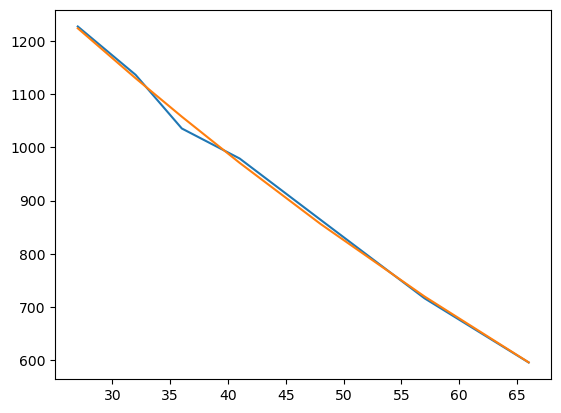

In [8]:
print(regressions_2.shape)

x = th0_dacs_list[:, 0]
y = (regressions_2[0,0,200,200]*x**2) + (regressions_2[1,0,200,200]*x) + regressions_2[2,0,200,200]
print(regressions_2[:,0,200,200])
# print()
plt.plot(x, spectral_projs_th0[:,0,200,200])
plt.plot(x,y)
plt.show()
# print(regressions_2[2,0,200,200])

In [9]:
# ni_img = nib.Nifti1Image(spectral_projs_th0[10,:,:,:], np.eye(4)) # Do not change this to make_nifti1Image function as we do not need the geo params for this
# s.save_array(results_folder, 'Proj_th0_'+str(th0_list[10])+'proj_org.nii', ni_img)

# for i in range (spectral_projs_th0.shape[0]):
#     print(i, np.mean(spectral_projs_th0[i,:,:,:]))
#     print(i, np.count_nonzero(spectral_projs_th0[i,:,:,:] == 0))

Finding best DAC values per pixel...


  0%|          | 0/512 [00:00<?, ?it/s]

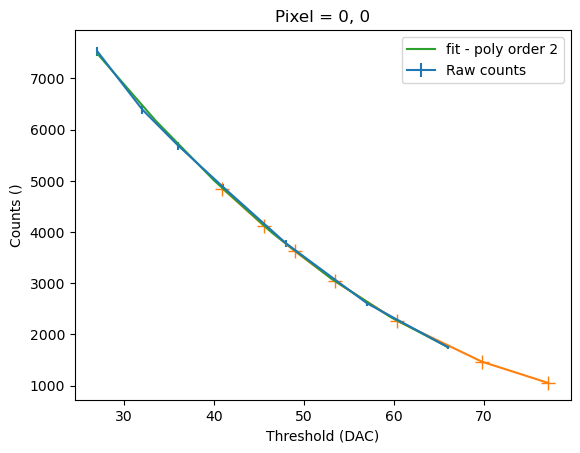

c:\Software\Tigre\Python\demos\shared_functions.py:789: ComplexWarning: Casting complex values to real discards the imaginary part
  dac_correct[dac, i, j] = dac_corr
c:\Software\Tigre\Python\demos\shared_functions.py:790: ComplexWarning: Casting complex values to real discards the imaginary part
  open_img_out[:, i, j] = (poly_coeffs[0] * dac_corr**2) + (poly_coeffs[1]*dac_corr) + poly_coeffs[2]
100%|██████████| 7/7 [00:00<00:00, 127.16it/s]


Saving numpy file: f:\jasper\data\20220929_Legoman_al_filter_100_um\results_navrit\all_dac_values.npy


  0%|          | 0/7 [00:00<?, ?it/s]

Saving Numpy array file: f:\jasper\data\20220929_Legoman_al_filter_100_um\results_navrit\Projections_th0_4.0_DAC.npy


C:\Users\navrit\AppData\Local\Temp\ipykernel_115112\1140301065.py:39: RuntimeWarning: invalid value encountered in log
  ofc = -np.log(corrected_projection_data/median)


Saving Numpy array file: f:\jasper\data\20220929_Legoman_al_filter_100_um\results_navrit\projs_th0_4.0OFC_interp.npy
Doing median filter on OFC data...
Saving numpy file: f:\jasper\data\20220929_Legoman_al_filter_100_um\results_navrit\th0_bpc.npy
-0.0 -0.0
-0.0 -0.0
-1.45


100%|██████████| 40/40 [00:13<00:00,  2.91it/s]


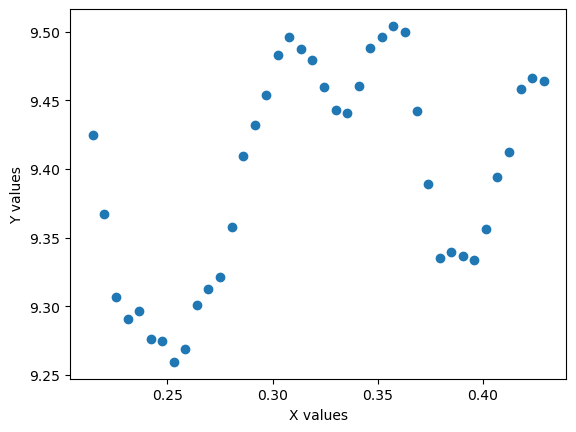

0 0.3575
Doing recon finally!
dsd:  188.347 dso:  148.0
Saving Nifti array file: f:\jasper\data\20220929_Legoman_al_filter_100_um\results_navrit\Recon_th0_4.0OFC_BPC.nii
dsd:  188.347 dso:  148.0
Saving Nifti array file: f:\jasper\data\20220929_Legoman_al_filter_100_um\results_navrit\Recon_th0_4.0OFC_BPC_MF3.nii


 14%|█▍        | 1/7 [00:54<05:24, 54.07s/it]

Saving Numpy array file: f:\jasper\data\20220929_Legoman_al_filter_100_um\results_navrit\Projections_th0_5.2_DAC.npy
Saving Numpy array file: f:\jasper\data\20220929_Legoman_al_filter_100_um\results_navrit\projs_th0_5.2OFC_interp.npy
Doing median filter on OFC data...
Saving numpy file: f:\jasper\data\20220929_Legoman_al_filter_100_um\results_navrit\th1_bpc.npy
-0.0 -0.0
-0.0 -0.0
-2.155


100%|██████████| 40/40 [00:13<00:00,  3.01it/s]


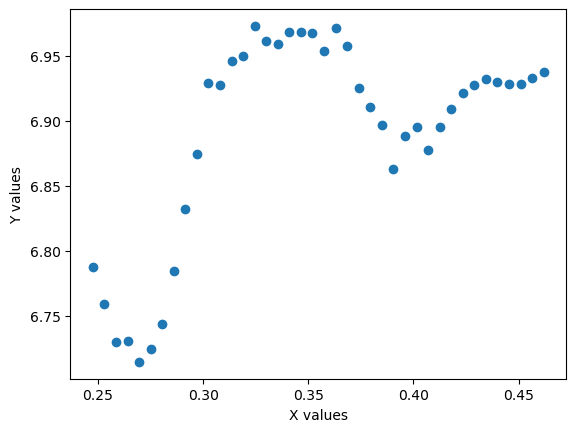

1 0.3245
Doing recon finally!
dsd:  188.347 dso:  148.0
Saving Nifti array file: f:\jasper\data\20220929_Legoman_al_filter_100_um\results_navrit\Recon_th0_5.2OFC_BPC.nii
dsd:  188.347 dso:  148.0
Saving Nifti array file: f:\jasper\data\20220929_Legoman_al_filter_100_um\results_navrit\Recon_th0_5.2OFC_BPC_MF3.nii


 29%|██▊       | 2/7 [01:39<04:05, 49.11s/it]

Saving Numpy array file: f:\jasper\data\20220929_Legoman_al_filter_100_um\results_navrit\Projections_th0_6.0_DAC.npy
Saving Numpy array file: f:\jasper\data\20220929_Legoman_al_filter_100_um\results_navrit\projs_th0_6.0OFC_interp.npy
Doing median filter on OFC data...
Saving numpy file: f:\jasper\data\20220929_Legoman_al_filter_100_um\results_navrit\th2_bpc.npy
-0.0 -0.0
-0.0 -0.0
-2.01


100%|██████████| 40/40 [00:13<00:00,  3.02it/s]


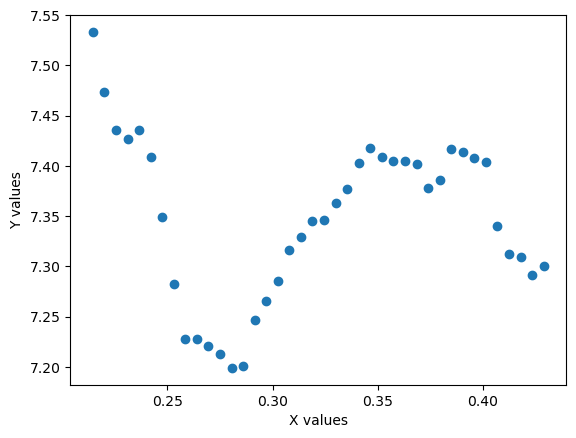

2 0.2145
Doing recon finally!
dsd:  188.347 dso:  148.0
Saving Nifti array file: f:\jasper\data\20220929_Legoman_al_filter_100_um\results_navrit\Recon_th0_6.0OFC_BPC.nii
dsd:  188.347 dso:  148.0
Saving Nifti array file: f:\jasper\data\20220929_Legoman_al_filter_100_um\results_navrit\Recon_th0_6.0OFC_BPC_MF3.nii


 43%|████▎     | 3/7 [02:25<03:10, 47.72s/it]

Saving Numpy array file: f:\jasper\data\20220929_Legoman_al_filter_100_um\results_navrit\Projections_th0_7.0_DAC.npy
Saving Numpy array file: f:\jasper\data\20220929_Legoman_al_filter_100_um\results_navrit\projs_th0_7.0OFC_interp.npy
Doing median filter on OFC data...
Saving numpy file: f:\jasper\data\20220929_Legoman_al_filter_100_um\results_navrit\th3_bpc.npy
-0.0 -0.0
-0.0 -0.0
-0.5


100%|██████████| 40/40 [00:13<00:00,  2.90it/s]


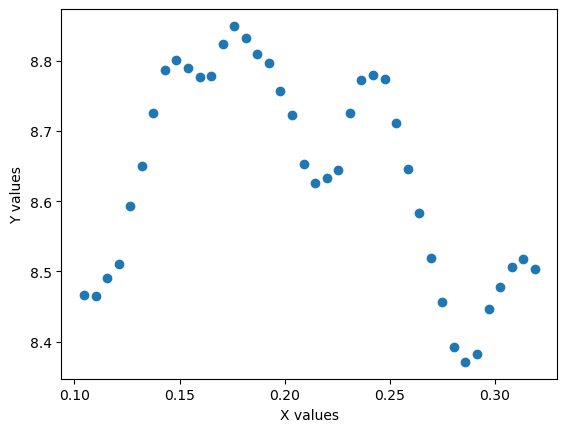

3 0.17600000000000002
Doing recon finally!
dsd:  188.347 dso:  148.0
Saving Nifti array file: f:\jasper\data\20220929_Legoman_al_filter_100_um\results_navrit\Recon_th0_7.0OFC_BPC.nii
dsd:  188.347 dso:  148.0
Saving Nifti array file: f:\jasper\data\20220929_Legoman_al_filter_100_um\results_navrit\Recon_th0_7.0OFC_BPC_MF3.nii


 57%|█████▋    | 4/7 [03:12<02:21, 47.28s/it]

Saving Numpy array file: f:\jasper\data\20220929_Legoman_al_filter_100_um\results_navrit\Projections_th0_8.5_DAC.npy
Saving Numpy array file: f:\jasper\data\20220929_Legoman_al_filter_100_um\results_navrit\projs_th0_8.5OFC_interp.npy
Doing median filter on OFC data...
Saving numpy file: f:\jasper\data\20220929_Legoman_al_filter_100_um\results_navrit\th4_bpc.npy
-0.0 -0.0
-0.0 -0.0
-1.405


100%|██████████| 40/40 [00:13<00:00,  2.99it/s]


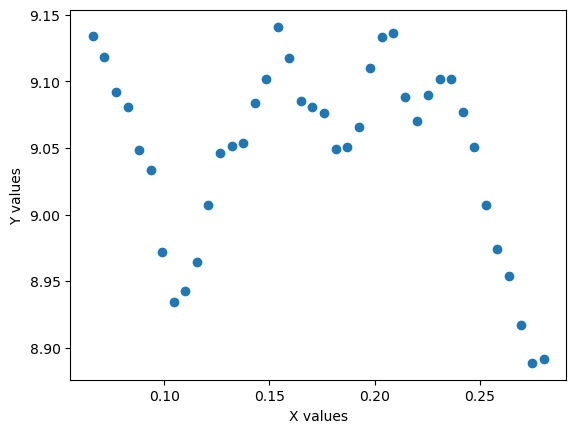

4 0.154
Doing recon finally!
dsd:  188.347 dso:  148.0
Saving Nifti array file: f:\jasper\data\20220929_Legoman_al_filter_100_um\results_navrit\Recon_th0_8.5OFC_BPC.nii
dsd:  188.347 dso:  148.0
Saving Nifti array file: f:\jasper\data\20220929_Legoman_al_filter_100_um\results_navrit\Recon_th0_8.5OFC_BPC_MF3.nii


 71%|███████▏  | 5/7 [03:58<01:33, 46.82s/it]

Saving Numpy array file: f:\jasper\data\20220929_Legoman_al_filter_100_um\results_navrit\Projections_th0_10.5_DAC.npy
Saving Numpy array file: f:\jasper\data\20220929_Legoman_al_filter_100_um\results_navrit\projs_th0_10.5OFC_interp.npy
Doing median filter on OFC data...
Saving numpy file: f:\jasper\data\20220929_Legoman_al_filter_100_um\results_navrit\th5_bpc.npy
-0.0 -0.0
-0.0 -0.0
-1.485


100%|██████████| 40/40 [00:11<00:00,  3.44it/s]


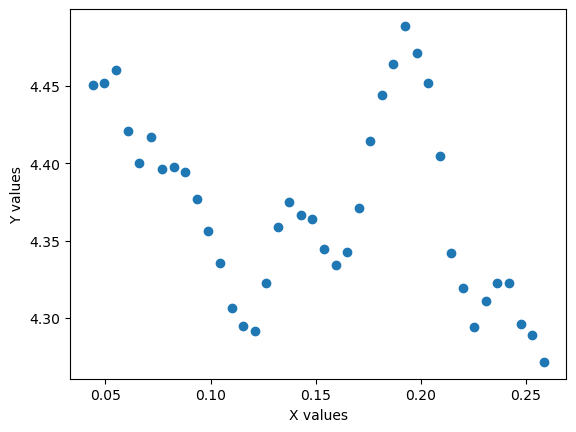

5 0.1925
Doing recon finally!
dsd:  188.347 dso:  148.0
Saving Nifti array file: f:\jasper\data\20220929_Legoman_al_filter_100_um\results_navrit\Recon_th0_10.5OFC_BPC.nii
dsd:  188.347 dso:  148.0
Saving Nifti array file: f:\jasper\data\20220929_Legoman_al_filter_100_um\results_navrit\Recon_th0_10.5OFC_BPC_MF3.nii


 86%|████████▌ | 6/7 [04:43<00:46, 46.10s/it]

Saving Numpy array file: f:\jasper\data\20220929_Legoman_al_filter_100_um\results_navrit\Projections_th0_12.5_DAC.npy
Saving Numpy array file: f:\jasper\data\20220929_Legoman_al_filter_100_um\results_navrit\projs_th0_12.5OFC_interp.npy
Doing median filter on OFC data...
Saving numpy file: f:\jasper\data\20220929_Legoman_al_filter_100_um\results_navrit\th6_bpc.npy
-0.0 -0.0
-0.0 -0.0
-81.895


100%|██████████| 40/40 [00:12<00:00,  3.29it/s]


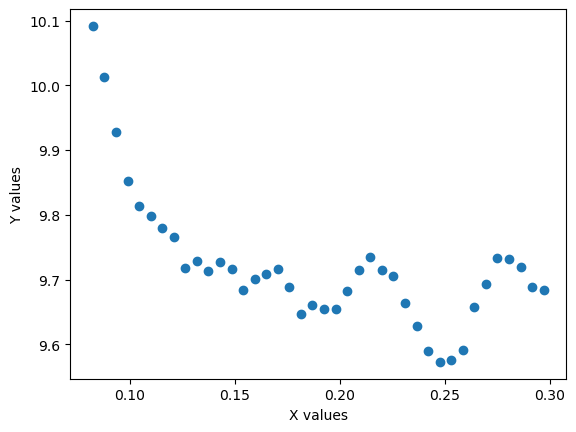

6 0.0825
Doing recon finally!
dsd:  188.347 dso:  148.0
Saving Nifti array file: f:\jasper\data\20220929_Legoman_al_filter_100_um\results_navrit\Recon_th0_12.5OFC_BPC.nii
dsd:  188.347 dso:  148.0
Saving Nifti array file: f:\jasper\data\20220929_Legoman_al_filter_100_um\results_navrit\Recon_th0_12.5OFC_BPC_MF3.nii


100%|██████████| 7/7 [05:27<00:00, 46.77s/it]


In [11]:
print('Finding best DAC values per pixel...')    

# E.g. shape = (21, 512, 512)
corrected_DAC_values_from_open_images = s.save_and_or_load_npy_files(
        results_folder, f'all_dac_values.npy', lambda: s.generate_correct_dac_values(gReconParams, open_mean_th0_all_dacs, th0_dacs_list, (0,1,2,3), plot=True, poly_order=2, open_img_path=results_folder))

for dac in trange(0, spectral_projs_th0.shape[0]):
    '''
    for t in scanned_thresholds:
        for p in projections:
            x = get correct dac for this pixel
            f = fit / interpolate for this pixel, using projection data
            y = f(x) --- get corresponding y value for that x
            img[t,p,i,j] = y
    '''
    d = corrected_DAC_values_from_open_images[dac] # (512, 512)
    # print(spectral_projs_th0.shape) # (21, 360, 512, 512)
    corrected_dacs_from_open_images_for_n_projections = np.repeat(d[np.newaxis, :, :], spectral_projs_th0.shape[1], axis=0).flatten() # (Projections, x/y, y/x) FLATTENED
    # print(calc_dacs.shape) # (94371840,) = flat(360, 512, 512)
    # proj_data_fits = (3, 360, 512, 512)
    proj_data_fits_flat = proj_data_fits.reshape(proj_data_fits.shape[0], -1) # Transpose and flatten projection data
    # print(proj_data_fits_flat.shape) # (3, 94371840) = 3 * flat(360, 512, 512)
    reconstructed_proj_data_flat = (proj_data_fits_flat[0, :]*corrected_dacs_from_open_images_for_n_projections**2) + \
                                    (proj_data_fits_flat[1, :]*corrected_dacs_from_open_images_for_n_projections**1) + \
                                    proj_data_fits_flat[2, :] 
    # print(proj_data_flat.shape) # (94371840,) = flat(360, 512, 512)
    ###########################
    corrected_projection_data = reconstructed_proj_data_flat.reshape(spectral_projs_th0.shape[1], spectral_projs_th0.shape[2], spectral_projs_th0.shape[3])
    # print(projection_data.shape) # (360, 512, 512)
    

    
    # proj_data_flat.reshape(
    #     spectral_projs_th0.shape[1], spectral_projs_th0.shape[2], spectral_projs_th0.shape[3])
    s.save_array(results_folder, 'Projections_th0_' + str(th0_list[dac])+'_DAC.npy', corrected_projection_data)
    
    # TODO Ask Jasper about this VERY SUSPICIOUS CODE
    median = (np.nanmedian(corrected_projection_data[:, :, 0:10]) + np.nanmedian(corrected_projection_data[:, :, 503:513]))/2
    ofc = -np.log(corrected_projection_data/median)
    s.save_array(results_folder, 'projs_th0_'+str(th0_list[dac])+'OFC_interp.npy', ofc)

    ofc_bpc = s.save_and_or_load_npy_files(
            results_folder, f'th{dac}_bpc.npy', lambda: s.generate_bad_pixel_corrected_array(ofc, gReconParams))
    # TODO Removed this line below to see the effects of Median filter
    # ofc_bpc_mf = s.median_filter_projection_set(ofc_bpc, 3)
    # if th == 0:
    #     # print(f'th = {th}, finding optimal offset')
        
    #     centre_of_rotation_offset_x_mm = s.find_optimal_offset(gReconParams, ofc_bpc, angles, detector_x_offsets, detector_y_offsets, stage_offset=0, search_range=25)
    #     print(centre_of_rotation_offset_x_mm)
    #     # centre_of_rotation_offset_y_mm = -0.24
    #     # print(f'centre_of_rotation_offset_x_mm = {centre_of_rotation_offset_x_mm} (mm)')
    #     # print(f'centre_of_rotation_offset_y_mm = {centre_of_rotation_offset_y_mm} (mm)')
        
    #     # ni_img = nib.Nifti1Image(ofc_bpc_mf, np.eye(4)) # Do not change this to make_nifti1Image function as we do not need the geo params for this
    #     # s.save_array(results_folder, 'Proj_th0_'+str(th0_list[th])+'OFC_BPC_MF.nii', ni_img)
    #     ni_img = nib.Nifti1Image(spectral_projs_th0[th,:,:,:], np.eye(4)) # Do not change this to make_nifti1Image function as we do not need the geo params for this
    #     s.save_array(results_folder, 'Proj_th0_'+str(th0_list[th])+'proj_org.nii', ni_img)
    #     ni_img = nib.Nifti1Image(projection_data, np.eye(4)) # Do not change this to make_nifti1Image function as we do not need the geo params for this
    #     s.save_array(results_folder, 'Proj_th0_'+str(th0_list[th])+'proj_corr.nii', ni_img)
        
    #     # TODO related to the previous TODO : Remove the two line below and uncomment the previous two lines
    #     ni_img = nib.Nifti1Image(ofc_bpc, np.eye(4)) # Do not change this to make_nifti1Image function as we do not need the geo params for this
    #     s.save_array(results_folder, 'Proj_th0_'+str(th0_list[th])+'OFC_BPC_MF.nii', ni_img)
    if dac == 0:
        stage_offset =  0.325
    else:
        stage_offset = centre_of_rotation_offset_x_mm 
    centre_of_rotation_offset_x_mm = s.find_optimal_offset(gReconParams, ofc_bpc, angles, detector_x_offsets, detector_y_offsets, stage_offset=stage_offset, search_range=20)
    print(dac, centre_of_rotation_offset_x_mm)
    print('Doing recon finally!')
    img_th0, geo = s.recon_scan(gReconParams, ofc_bpc, angles, detector_x_offsets,
                         detector_y_offsets, centre_of_rotation_offset_x_mm, centre_of_rotation_offset_y_mm, True)
    
    ni_img = s.make_Nifti1Image(img_th0, geo.dVoxel)
    s.save_array(results_folder, 'Recon_th0_'+str(th0_list[dac])+'OFC_BPC.nii', ni_img)
    
    # ofc =-np.log(spectral_projs_th0[th,:,:,:]/mean)
    # img_th0, geo = s.recon_scan(gReconParams, ofc, angles, detector_x_offsets,
    #                      detector_y_offsets, centre_of_rotation_offset_x_mm, centre_of_rotation_offset_y_mm, True)
    # ni_img = s.make_Nifti1Image(img_th0, geo.dVoxel)
    # s.save_array(results_folder, 'Recon_th0_'+str(th0_list[th])+'OFC_only.nii', ni_img)
    
    ofc_bpc_mf = s.median_filter_projection_set(ofc_bpc, 3)
    img_th0, geo = s.recon_scan(gReconParams, ofc_bpc_mf, angles, detector_x_offsets,
                         detector_y_offsets, centre_of_rotation_offset_x_mm, centre_of_rotation_offset_y_mm, True)
    ni_img = s.make_Nifti1Image(img_th0, geo.dVoxel)
    s.save_array(results_folder, 'Recon_th0_'+str(th0_list[dac])+'OFC_BPC_MF3.nii', ni_img)

    # ofc_bpc_mf = s.median_filter_projection_set(ofc_bpc, 5)
    # img_th0, geo = s.recon_scan(gReconParams, ofc_bpc_mf, angles, detector_x_offsets,
    #                      detector_y_offsets, centre_of_rotation_offset_x_mm, centre_of_rotation_offset_y_mm, True)
    # ni_img = s.make_Nifti1Image(img_th0, geo.dVoxel)
    # s.save_array(results_folder, 'Recon_th0_'+str(th0_list[th])+'OFC_BPC_MF5.nii', ni_img)


In [ ]:
print(centre_of_rotation_offset_x_mm)
centre_of_rotation_offset_x_mm = s.find_optimal_offset(gReconParams, ofc_bpc, angles, detector_x_offsets, detector_y_offsets, stage_offset=0, search_range=35)

In [ ]:
print(f'th = {dac}, finding optimal offset')
global_detector_shift_y = .2 #find_optimal_offset(spectral_projs_th0[1, :, :, :], angles, detector_x_offsets, detector_y_offsets, stageoffset=0, searchrange=25)
print(f'global_detector_shift_y = {global_detector_shift_y} (mm)')

ni_img = nib.Nifti1Image(ofc_bpc_mf, np.eye(4))
s.save_array(results_folder, 'Proj_th0_'+str(th0_list[dac])+'OFC_BPC_MF.nii', ni_img)

print('Doing recon finally!')
img_th0 = s.recon_scan(gReconParams, ofc_bpc, angles, z_offset, detector_x_offsets,
                    detector_y_offsets, global_detector_shift_y)

ni_img = nib.Nifti1Image(img_th0, np.eye(4))
s.save_array(results_folder, 'Recon_th0_'+str(th0_list[dac])+'OFC_BPC.nii', ni_img)

img_th0 = s.recon_scan(gReconParams, ofc_bpc_mf, angles, z_offset, detector_x_offsets,
                    detector_y_offsets, global_detector_shift_y)
ni_img = nib.Nifti1Image(img_th0, np.eye(4))
s.save_array(results_folder, 'Recon_th0_'+str(th0_list[dac])+'OFC_BPC_MF.nii', ni_img)


In [ ]:
for th1 in range(0, open_mean_th1_all_dacs.shape[0]):
    mean = 0.25*(np.mean(open_mean_th1_all_dacs[th1, 0:255, 0:255]) + np.mean(open_mean_th1_all_dacs[th1, 0:255, 257:512]) + np.mean(
        open_mean_th1_all_dacs[th1, 257:512, 0:255]) + np.mean(open_mean_th1_all_dacs[th1, 257:512, 257:512]))
    print(mean)
    regression_out = np.zeros((3, 512, 512))
    DACvalues = np.zeros((512, 512))
    for i in range(0, open_mean_th1_all_dacs.shape[1]):
        for j in range(0, open_mean_th1_all_dacs.shape[2]):
            yvalues = open_mean_th1_all_dacs[:, i, j]
            regressions, res, _, _, _ = np.polyfit(th1_list, yvalues, 2, full=True)
            regression_out[:, i, j] = regressions
            DAC = s.solve_for_y(regressions, mean)[1]
            if (DAC > th1_list[th1]*2) or (DAC < th1_list[th1]/2):
                DAC = th1_list[th1]
            DACvalues[i, j] = DAC
    fitarray = spectral_projs_th1.reshape(spectral_projs_th1.shape[0], -1)
    regressions, res, _, _, _ = np.polyfit(th1_list, fitarray, 2, full=True)
    calcdacs = np.repeat(DACvalues[np.newaxis, :, :], spectral_projs_th1.shape[1], axis=0).flatten()

    projdataflat = (regressions[0, :]*calcdacs**2) + \
        (regressions[1, :]*calcdacs**1) + regressions[2, :]
    projectiondata = projdataflat.reshape(
        spectral_projs_th1.shape[1], spectral_projs_th1.shape[2], spectral_projs_th1.shape[3])
    np.save(os.path.join(results_folder, 'Projections_th1_'
            + str(th1_list[th1])+'_DAC.npy'), projectiondata)

    mean = (np.mean(projectiondata[:, :, 0:10]) + np.mean(projectiondata[:, :, 503:513]))/2
    ofc = -np.log(projectiondata/mean)
    ni_img = nib.Nifti1Image(ofc, np.eye(4))
    np.save(os.path.join(results_folder, 'projs_th1_'+str(th1_list[th1])+'OFC_interp.npy'), ofc)
    ofc_mf = s.median_filter_projection_set(ofc, 5)
    diff_mf = np.abs(ofc-ofc_mf)
    meanmap = np.mean(diff_mf, axis=0)
    stdmap = np.std(diff_mf, axis=0)
    badmap = np.ones((512, 512))
    half = np.int32(badmap.shape[0]/2)
    badmap[half-2:half+1] = 0
    badmap[:, half-2:half+1] = 0
    badmap[meanmap > 0.2] = 0
    badmap[stdmap > 0.05] = 0
    ofc_bpc = s.apply_badmap_to_projections(ofc, badmap)
    ofc_bpc_mf = s.median_filter_projection_set(ofc_bpc, 3)
    img_th1 = s.recon_scan(ofc_bpc, angles, z_offset, detector_x_offsets,
                         detector_y_offsets, global_detector_shift_y)
    ni_img = nib.Nifti1Image(img_th1, np.eye(4))
    nib.save(ni_img, os.path.join(results_folder, 'Recon_th1_'+str(th1_list[th1])+'OFC_BPC.nii'))
    img_th1 = s.recon_scan(ofc_bpc_mf, angles, z_offset, detector_x_offsets,
                         detector_y_offsets, global_detector_shift_y)
    ni_img = nib.Nifti1Image(img_th1, np.eye(4))
    nib.save(ni_img, os.path.join(results_folder, 'Recon_th1_'+str(th1_list[th1])+'OFC_BPC_MF.nii'))


In [ ]:

openmeansingle_th0 = np.mean(open_mean_th0_all_dacs, axis=(1, 2))
openmeansingle_th1 = np.mean(open_mean_th1_all_dacs, axis=(1, 2))
plt.scatter(th0_list, openmeansingle_th0, label="th0")
plt.scatter(th1_list, openmeansingle_th1, label="th1")


In [ ]:
# global_detector_shift_y = 0.37565
global_detector_shift_y = -0.31872500000000004

hyperlist = [500]
lambdalist = [0.010]
for hyper in hyperlist:
    for tvlambda in lambdalist:
        # hyper=2.0e3
        tviter = 100
        # tvlambda=0.005
        img_th0 = s.recon_scan_fista(ofc_2_mf.astype(np.float32), angles, z_offset, detector_x_offsets,
                                   detector_y_offsets, global_detector_shift_y, hyper, tviter, tvlambda)
        ni_img = nib.Nifti1Image(img_th0, np.eye(4))
        nib.save(ni_img, os.path.join(base_folder, 'recon_fista_mf_'
                 + str(tviter) + '_' + str(hyper)+'_'+str(tvlambda) + '.nii'))


In [ ]:
drive = 'f:\\'
# basefolder = os.path.join(drive,'jasper','data','20220726_scanseries')
base_folder = os.path.join(drive, 'jasper', 'data', '20220805_tumourWhateverBreast')
base_json_file = os.path.join(base_folder, 'scan_settings.json')
results_folder = os.path.join(base_folder, 'results_open_after')
if not os.path.exists(results_folder):
    os.makedirs(results_folder)
if os.path.exists(base_json_file):
    f = open(base_json_file)
    dashboard = json.load(f)
    spectral_projs_th0 = []
    spectral_open_th0 = []
    spectral_projs_th1 = []
    spectral_open_th1 = []
    th0_list = []
    exp_time = []
    th1_list = []
    th1_exp_time = []
    for i in dashboard['thresholdscan']:
        scan_folder = os.path.join(base_folder, dashboard['thresholdscan'][i]['projectionsfolder'])
        scan_json = os.path.join(scan_folder, dashboard['thresholdscan'][i]['projections_json'])
        open_image_folder = os.path.join(
            base_folder, dashboard['thresholdscan'][i]['openimagesfolder'])
        open_image_json = os.path.join(
            open_image_folder, dashboard['thresholdscan'][i]['openimages_json'])
        folder_string = dashboard['thresholdscan'][i]['projectionsfolder']
        th0_keV = folder_string[0:folder_string.find('_')]
        th1_keV = folder_string[folder_string.find('_')+1:]
        exp_time.append(s.get_exposure_time_projection(scan_json))
        th0_list.append(float(th0_keV))
        th1_list.append(float(th1_keV))

        projs_th0 = s.projectionsloader(
            scan_json, th0=True, badpixelcorr=gReconParams['bad_pixel_correction'], medianfilter=gReconParams['median_filter'], fillgap=gReconParams['fill_gap'])
        openimg_th0 = s.openimgloader(
            open_image_json, th0=True, badpixelcorr=gReconParams['bad_pixel_correction'], medianfilter=gReconParams['median_filter'], fillgap=gReconParams['fill_gap'])
        projs_th1 = s.projectionsloader(
            scan_json, th0=False, badpixelcorr=gReconParams['bad_pixel_correction'], medianfilter=gReconParams['median_filter'], fillgap=gReconParams['fill_gap'])
        openimg_th1 = s.openimgloader(
            open_image_json, th0=False, badpixelcorr=gReconParams['bad_pixel_correction'], medianfilter=gReconParams['median_filter'], fillgap=gReconParams['fill_gap'])
        spectral_projs_th0.append(projs_th0)
        spectral_open_th0.append(openimg_th0)
        spectral_projs_th1.append(projs_th1)
        spectral_open_th1.append(openimg_th1)
        detector_x_offsets, detector_y_offsets = s.get_detector_offsets(scan_json)
        angles = s.get_proj_angles(scan_json)
        z_offset = s.get_samplestage_z_offset(scan_json)
    spectral_projs_th0 = np.asarray(spectral_projs_th0)
    spectral_open_th0 = np.asarray(spectral_open_th0)
    spectral_projs_th1 = np.asarray(spectral_projs_th1)
    spectral_open_th1 = np.asarray(spectral_open_th1)
    exp_time = np.asarray(exp_time)
    th0_list = np.asarray(th0_list)
    th1_list = np.asarray(th1_list)

    np.save(os.path.join(results_folder, 'projs_stack_th0.npy'), spectral_projs_th0)
    np.save(os.path.join(results_folder, 'open_stack_th0.npy'), spectral_open_th0)
    np.save(os.path.join(results_folder, 'projs_stack_th1.npy'), spectral_projs_th1)
    np.save(os.path.join(results_folder, 'open_stack_th1.npy'), spectral_open_th1)
    np.save(os.path.join(results_folder, 'thlist_th0.npy'), th0_list)
    np.save(os.path.join(results_folder, 'thlist_th1.npy'), th1_list)

    # print(spectralprojs.shape, spectralopen.shape)
    # out = np.load(os.path.join(basefolder,'Projections_fitted.npy'))
    # openout = np.load(os.path.join(basefolder,'Projections_open_fitted.npy'))


In [ ]:
drive = 'f:\\'
basefolder = os.path.join(drive, 'jasper', 'data', '20220603_RealTumor')
basejsonfile = os.path.join(basefolder, 'scan_settings.json')

if os.path.exists(basejsonfile):
    f = open(basejsonfile)
    dashboard = json.load(f)
    for i in dashboard['thresholdscan']:
        scanfolder = os.path.join(basefolder, dashboard['thresholdscan'][i]['projectionsfolder'])
        scanjson = os.path.join(scanfolder, dashboard['thresholdscan'][i]['projections_json'])
        detector_x_offsets, detector_y_offsets = s.get_detector_offsets(scanjson)
        angles = s.get_proj_angles(scanjson)
        z_offset = s.get_samplestage_z_offset(scanjson)
        projs_th0 = s.get_OFC_projections(scanjson, th0=True, UseOrig=False, ApplyLog=True)

        # projectionsCorr = tomopy.prep.stripe.remove_all_stripe(projs_th0, snr=3, la_size=61, sm_size=21, dim=1, ncore=60, nchunk=None)
        projectionsCorr = tomopy.prep.stripe.remove_stripe_fw(
            projs_th0, level=None, wname='db5', sigma=0.2, pad=True, ncore=60, nchunk=None)
        # global_detector_shift_y = find_optimal_offset(projs_th0, angles, detector_x_offsets, detector_y_offsets, z_offset)
        global_detector_shift_y = 0.1915
        gReconVoxels = (600, 512, 512)             # number of voxels              (vx)
        gReconSize = (15, 12.8, 12.8)          # total size of the image       (mm)

        img_th0 = s.recon_scan(projs_th0, angles, z_offset, detector_x_offsets,
                             detector_y_offsets, global_detector_shift_y)
        ni_img = nib.Nifti1Image(img_th0, np.eye(4))
        nib.save(ni_img, os.path.join(basefolder, 'recon_'+str(0)+'_th0_orig.nii'))
        # imgfdk = tomopy.misc.corr.remove_ring(img_th0, center_x=None, center_y=None, thresh=1000.0, thresh_max=5000.0, thresh_min=10.0, theta_min=50, rwidth=10, int_mode='WRAP', ncore=60, nchunk=None, out=None)
        # ni_img = nib.Nifti1Image(imgfdk, np.eye(4))
        # nib.save(ni_img,  os.path.join(basefolder,'recon_'+str(0)+'_th0_corr_pre_post.nii'))
        img_th0 = s.recon_scan(projectionsCorr, angles, z_offset, detector_x_offsets,
                             detector_y_offsets, global_detector_shift_y)
        ni_img = nib.Nifti1Image(img_th0, np.eye(4))
        nib.save(ni_img, os.path.join(basefolder, 'recon_'+str(0)+'_th0_corr2.nii'))
